## INDEX
### 1. 데이터 전처리 및 변수설정(feature 1~5)
### 2. 군집화(8) - 돌봄센터 공급 우선 지역 선정(강서구, 기장군)
### 3. 결론 및 시각화(우선 공급(기준: 초등학교))

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

import numpy as np
import pandas as pd
import re, requests, json

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['axes.unicode_minus'] = False
import seaborn as sns
plt.rc('font', family='NanumGothic')
%matplotlib inline
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import branca.colormap as cm

from haversine import haversine
from collections import defaultdict

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering

## 1. 데이터 전처리
### 데이터 리스트
- micro_df: 인구주택 총조사 2% 마이크로 데이터(by 통계청)
- ingu_df: 연령별 인구현황(by 통계청)
- income_df: 구별 종합 소득, 세금 현황(by 통계청)
- school_df: 학교현황(after_school_df + school_address_df)
- after_school_df: 방과후학교 운영 계획 및 운영, 지원 현황(by 공공데이터)
- school_address: 학교주소(웹크롤링)(by 공공데이터)
- dolbom_df: 돌봄센터 리스트(dolbom1+...+dolbom4)
- dolbom1: 다함께돌봄센터(by 부산시청 요청)
- dolbom2: 아동복지시설(by 부산시청 요청)
- dolbom3: 우리동네자람텀(by 부산시청 요청)
- dolbom4: 지역아동센터(by 부산시청 요청)

#### micro_df 전처리
인구주택 총조사 2% 마이크로 데이터(by 통계청)
- state_code에 nan값 존재 0으로 대체
- code: 개체
- year: 만나이
- relation_code(가구주관계코드): {'01':본인(가구주),'02':배우자,'03':자녀,...}
- state_code(경제활동상태): {1:주로 일하였음, 2:틈틈이 일하였음, 3:일시휴직, 4:일하지 않았음}

In [2]:
# 법정동
gu_list = {'010':'중구', '020':'서구', '030':'동구', '040':'영도구', '050':'부산진구', '060':'동래구','070':'남구','080':'북구',
 '090':'해운대구','100':'사하구','110':'금정구','120':'강서구', '130':'연제구','140':'수영구','150':'사상구','310':'기장군'}

In [3]:
micro_df = pd.read_csv("C:/Users/dongjae/[marketing]/data/micro.csv", encoding='cp949')
micro_df.columns = ['id','gu_code','year','relation_code','state_code']
# micro_df[micro_df['state_code'].isnull()]['year'].unique() # year: 0~14 어린이 확인
micro_df['state_code'].fillna(0, inplace=True) # 어린이 경제활동상태 0으로 처리
micro_df['state_code'] = micro_df['state_code'].astype('int64')
micro_df['si'] = micro_df['id'].apply(lambda x:str(x)[:2]).tolist() # 시
micro_df['gu'] = micro_df['id'].apply(lambda x:str(x)[2:5]).tolist() # 구군
micro_df['code'] = micro_df['id'].apply(lambda x:str(x)[5:]).tolist() # 가구코드
micro_df = micro_df[micro_df['si'] == '21'] # 21: 부산광역시
micro_df = micro_df.loc[:,['id','gu','code','year','relation_code','state_code']]
micro_df['gu'] = micro_df['gu'].replace(gu_list)
display(micro_df)

,id,gu,code,year,relation_code,state_code
145817,2101000011,중구,00011,32,1,2
145818,2101000019,중구,00019,48,1,4
145819,2101000022,중구,00022,3,3,0
145820,2101000022,중구,00022,36,1,4
145821,2101000022,중구,00022,6,3,0
...,...,...,...,...,...,...
207029,2131015163,기장군,15163,34,2,1
207030,2131015163,기장군,15163,40,1,1
207031,2131015163,기장군,15163,6,3,0
207032,2131015168,기장군,15168,48,1,1


#### ingu_df 전처리
연령별 인구현황(by 통계청)

In [4]:
ingu_df = pd.read_csv("C:/Users/dongjae/[marketing]/data/ingu.csv", encoding='cp949')
ingu_df = ingu_df.iloc[1:,[0,3,4,5,6,7,8]]
ingu_df.columns = ['gu','6y','7y','8y','9y','10y','11y']
ingu_df['gu'] = ingu_df['gu'].apply(lambda x:re.findall('\w+',x)[1]) # 구군
for col in ingu_df.iloc[:,1:].columns:
    ingu_df[col] = ingu_df[col].apply(lambda x:re.sub('[^\w]','',x)).astype('float')
ingu_df['total'] = ingu_df.iloc[:,1:].sum(axis=1)
display(ingu_df)

,gu,6y,7y,8y,9y,10y,11y,total
1,중구,111.0,136.0,153.0,139.0,170.0,168.0,877.0
2,서구,649.0,679.0,662.0,662.0,722.0,751.0,4125.0
3,동구,426.0,454.0,420.0,435.0,485.0,447.0,2667.0
4,영도구,570.0,562.0,615.0,602.0,677.0,706.0,3732.0
5,부산진구,2261.0,2323.0,2275.0,2245.0,2454.0,2444.0,14002.0
6,동래구,2387.0,2542.0,2562.0,2525.0,2719.0,2726.0,15461.0
7,남구,1957.0,2050.0,2093.0,2144.0,2334.0,2275.0,12853.0
8,북구,2106.0,2123.0,2087.0,2098.0,2212.0,2199.0,12825.0
9,해운대구,3083.0,3356.0,3263.0,3521.0,3630.0,3734.0,20587.0
10,사하구,2079.0,2159.0,2200.0,2282.0,2457.0,2532.0,13709.0


#### income_df 전처리
구별 종합 소득, 세금 현황(by 통계청)
- 단위: 백만원
- 종합소득 : 개인인 1년 동안 벌어들인 ①이자 ②배당 ③사업 ④근로 ⑤연금 ⑥기타소득 등 6가지에 대한 소득을 종합하여 과세하는 소득을 말한다.

In [5]:
income_df = pd.read_csv("C:/Users/dongjae/[marketing]/data/income.csv", encoding='cp949', skiprows=1)
income_df = income_df[income_df['시군구별(1)']=='부산'].reset_index()
income_df = income_df.iloc[1:,[2,5]] # 종합소득금액(백만원)
income_df.columns = ['gu','income']
income_df.reset_index(inplace=True)
income_df.drop('index',axis=1,inplace=True)
display(income_df)

,gu,income
0,강서구,745321
1,금정구,1127147
2,기장군,538645
3,남구,1386487
4,동구,240206
5,동래구,1316891
6,부산진구,1327026
7,북구,1009625
8,사상구,602608
9,사하구,885396


#### school_df와 after_school_df, school_address_df 전처리
after_school_df: 방과후학교 운영 계획 및 운영, 지원 현황(by 공공데이터)

school_address: 학교주소(웹크롤링)(by 공공데이터)

school_df: 학교현황(after_school_df + school_address_df)
- after_school_df와 school_address_df를 이용
- 부산 내에 중복된 이름을 가진 학교 존재 '송정초등학교' 
- 중복값은 해당구+학교명으로 엑셀에서 처리 school_address.csv와 after_school 모두
- 서곡초등학교에 대한 주소정보 없음, 올해 폐교된 곳

In [6]:
after_school_df = pd.read_csv("C:/Users/dongjae/[marketing]/data/after_school.csv", encoding='utf-8')
after_school_df = after_school_df.iloc[:,[2,3,8]]
after_school_df.columns=['gu','name','total']
after_school_df['gu'] = after_school_df['gu'].apply(lambda x : x.replace('부산광역시','').replace(' ',''))
display(after_school_df)

,gu,name,total
0,연제구,부산교육대학교부설초등학교,448
1,중구,광일초등학교,296
2,중구,남성초등학교,248
3,남구,대남초등학교,181
4,남구,대연초등학교,1011
...,...,...,...
299,강서구,신명초등학교,640
300,강서구,명일초등학교,379
301,강서구,명원초등학교,539
302,기장군,일광초등학교,488


In [7]:
school_address_df = pd.read_csv("C:/Users/dongjae/[marketing]/data/school_address.csv", encoding='cp949')
school_address_df.columns=['name','address']
display(school_address_df)

,name,address
0,호암초등학교,부산광역시 수영구 호암로 57
1,해원초등학교,부산광역시 해운대구 마린시티2로 10
2,해운대초등학교,부산광역시 해운대구 중동2로24번길 30
3,해송초등학교,부산광역시 해운대구 좌동순환로402번길 32
4,해빛초등학교,부산광역시 기장군 일광면 해빛6로 9
...,...,...
299,구평초등학교,부산광역시 사하구 사하로 9
300,구덕초등학교,부산광역시 서구 보수대로 312
301,괴정초등학교,부산광역시 사하구 낙동대로 152
302,광일초등학교,부산광역시 중구 중구로 74


In [8]:
school_df = pd.merge(after_school_df, school_address_df, on = 'name')
display(school_df) ## 303rows: 서곡초등학교(폐교) 제외

,gu,name,total,address
0,연제구,부산교육대학교부설초등학교,448,부산광역시 연제구 교대로 24
1,중구,광일초등학교,296,부산광역시 중구 중구로 74
2,중구,남성초등학교,248,부산광역시 중구 샘길 14
3,남구,대남초등학교,181,부산광역시 남구 황령대로353번길 9-55
4,남구,대연초등학교,1011,부산광역시 남구 진남로18번길 11
...,...,...,...,...
298,강서구,신명초등학교,640,부산광역시 강서구 명지국제7로 178
299,강서구,명일초등학교,379,부산광역시 강서구 명지국제5로 170-5
300,강서구,명원초등학교,539,부산광역시 강서구 명지국제6로 147
301,기장군,일광초등학교,488,부산광역시 기장군 일광면 해빛로 46


#### dolbom_df 
- dolbom1: 다함께돌봄센터(by 부산시청 요청)
- dolbom2: 아동복지시설(by 부산시청 요청)
- dolbom3: 우리동네자람텀(by 부산시청 요청)
- dolbom4: 지역아동센터(by 부산시청 요청)
- dolbom_df: 돌봄센터 리스트(dolbom1+...+dolbom4)

In [9]:
dolbom1 = pd.read_csv("C:/Users/dongjae/[marketing]/data/dolbdom/다함께돌봄센터.csv",encoding='utf-8')
dolbom1.columns = ['gu','name','address','n','total']
# display(dolbom1) 시청직원의 요청으로 공개X

In [10]:
dolbom2 = pd.read_csv("C:/Users/dongjae/[marketing]/data/dolbdom/아동복지시설.csv",encoding='utf-8')
dolbom2['구'] = dolbom2['소재지'].apply(lambda x:re.sub(' .+','',x))
dolbom2.columns = ['name','address','total','n','gu']
dolbom2 = dolbom2[['gu','name','address','n','total']]
# display(dolbom2) 시청직원의 요청으로 공개X

In [11]:
dolbom3 = pd.read_csv("C:/Users/dongjae/[marketing]/data/dolbdom/우리동네자람터.csv", encoding='utf-8')
dolbom3.columns = ['gu','name','address','total','n']
dolbom3 = dolbom3[['gu','name','address','n','total']]
# display(dolbom3) 시청직원의 요청으로 공개X

In [12]:
dolbom4 = pd.read_excel("C:/Users/dongjae/[marketing]/data/dolbdom/지역아동센터.xlsx")
dolbom4 = dolbom4.iloc[:,[1,2,5,4,3]]
dolbom4.columns=['gu','name','address','n','total']
# display(dolbom4) 시청직원의 요청으로 공개X

In [13]:
dolbom_df = pd.concat([dolbom1,dolbom2,dolbom3,dolbom4]).sort_values('gu').reset_index().drop('index',axis=1)
# display(dolbom_df)

### 변수설정
1. 초등 1학년 ~ 4학년 인구수, ingu_df
2. 맞벌이 가구 비율, micro_df
3. 소득수준, income_df
4. 돌봄시설 공급률(포화율), (수용가능자/이용자), dolbom_df,   
5. 초등학교와 돌봄시설 사이 거리, school_df, dolbom_df

#### feature1. 초등학생수(1~4학년)
- 만나이 6세~11세 합계

In [14]:
feature1 = ingu_df[['gu','total']].sort_values('gu').reset_index().drop('index',axis=1)
feature1.columns = ['gu','elementryStudent']
display(feature1)

,gu,elementryStudent
0,강서구,13161.0
1,금정구,9082.0
2,기장군,13400.0
3,남구,12853.0
4,동구,2667.0
5,동래구,15461.0
6,부산진구,14002.0
7,북구,12825.0
8,사상구,8064.0
9,사하구,13709.0


#### feature2. 맞벌이 가구 비율
1. 아이가구선정 2. 부모님 2명 가구 선정 3. 2명 경제활동상태 1,2,3 선정
- relation_code(가구주관계코드): {'01':본인(가구주),'02':배우자,'03':자녀,...}
- state_code(경제활동상태):{1:주로 일하였음, 2:틈틈이 일하였음, 3:일시휴직, 4:일하지 않았음}

In [15]:
child_family_id = micro_df[(micro_df['relation_code']==3)& (micro_df['year'] >=6) & (micro_df['year'] <=11)]['id'].unique() # 6~11세 자녀(relation_code:3)가 존재하는 가구 id
child_family_df = micro_df.loc[micro_df['id'].isin(child_family_id),:]
display(child_family_df)

,id,gu,code,year,relation_code,state_code
145819,2101000022,중구,00022,3,3,0
145820,2101000022,중구,00022,36,1,4
145821,2101000022,중구,00022,6,3,0
145870,2101000341,중구,00341,10,3,0
145871,2101000341,중구,00341,39,2,3
...,...,...,...,...,...,...
207026,2131015154,기장군,15154,46,1,1
207027,2131015154,기장군,15154,7,3,0
207029,2131015163,기장군,15163,34,2,1
207030,2131015163,기장군,15163,40,1,1


In [16]:
pd.set_option('mode.chained_assignment',  None)
parents_df = child_family_df.loc[(child_family_df['relation_code']==1)|(child_family_df['relation_code']==2),:]
parents_num = parents_df['id'].value_counts() # 부모님 수
parents_df.set_index('id', inplace=True)
parents_df.loc[:,'parents_n'] = parents_num
parents_df = parents_df[parents_df['parents_n']==2].reset_index()
parents_df = parents_df[['id','gu','year','relation_code','state_code']]
display(parents_df)
pd.set_option('mode.chained_assignment',  'warn')

,id,gu,year,relation_code,state_code
0,2101000341,중구,39,2,3
1,2101000341,중구,44,1,1
2,2101000371,중구,36,2,4
3,2101000371,중구,40,1,1
4,2101000740,중구,44,2,3
...,...,...,...,...,...
3669,2131015037,기장군,46,2,1
3670,2131015154,기장군,38,2,1
3671,2131015154,기장군,46,1,1
3672,2131015163,기장군,34,2,1


In [17]:
work_df = parents_df.copy()
work_df.loc[work_df['state_code']!=4,'work']=1
work_df.set_index('id', inplace=True)
work_df['work_num'] = work_df.groupby('id')['work'].sum()
work_df.reset_index(inplace=True)
work_df = work_df[work_df['work_num']==2] # 맞벌이
display(work_df)

,id,gu,year,relation_code,state_code,work,work_num
0,2101000341,중구,39,2,3,1.0,2.0
1,2101000341,중구,44,1,1,1.0,2.0
4,2101000740,중구,44,2,3,1.0,2.0
5,2101000740,중구,48,1,1,1.0,2.0
8,2101001079,중구,38,1,1,1.0,2.0
...,...,...,...,...,...,...,...
3669,2131015037,기장군,46,2,1,1.0,2.0
3670,2131015154,기장군,38,2,1,1.0,2.0
3671,2131015154,기장군,46,1,1,1.0,2.0
3672,2131015163,기장군,34,2,1,1.0,2.0


In [18]:
feature2 = pd.DataFrame(work_df.groupby('gu')['id'].agg('count') / parents_df.groupby('gu')['id'].agg('count')).reset_index()
feature2.columns =['gu','doubleIncome_Rate']
display(feature2)

,gu,doubleIncome_Rate
0,강서구,0.574803
1,금정구,0.578431
2,기장군,0.475309
3,남구,0.506494
4,동구,0.478261
5,동래구,0.594771
6,부산진구,0.508197
7,북구,0.550847
8,사상구,0.541284
9,사하구,0.496503


#### feature3. 소득수준

In [19]:
feature3 = income_df.sort_values('gu').set_index('gu').astype('float64').reset_index()
display(feature3)

,gu,income
0,강서구,745321.0
1,금정구,1127147.0
2,기장군,538645.0
3,남구,1386487.0
4,동구,240206.0
5,동래구,1316891.0
6,부산진구,1327026.0
7,북구,1009625.0
8,사상구,602608.0
9,사하구,885396.0


#### feature4. 돌봄시설 공급률

In [20]:
temp_df = dolbom_df.groupby(['gu'])[['n','total']].agg(sum).reset_index()
temp_df['p'] = temp_df['total']/temp_df['n']
feature4 = temp_df[['gu','p']]
feature4.columns = ['gu','dolbomCenter_supplyRate']
display(feature4)

,gu,dolbomCenter_supplyRate
0,강서구,1.110687
1,금정구,1.296578
2,기장군,0.993274
3,남구,1.089256
4,동구,1.146341
5,동래구,1.127628
6,부산진구,1.044218
7,북구,1.064935
8,사상구,0.983636
9,사하구,1.030769


#### feature5. 초등학교와 돌봄시설간에 거리
1. 학교위치(위도, 경도)검색 2. 돌봄센터(위도, 경도)검색 3. 거리 계산, 가장 가까운 거리 기준

- kakao api로 검색이 안되는 장소는 수작업으로 재가공

In [21]:
def get_location(address): # KAKAO API
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + address
    headers = {"Authorization": "KakaoAK a166aea7ac532485d79f91973c28bdb6"}
    api_json = json.loads(str(requests.get(url,headers=headers).text))
    address = api_json['documents'][0]['address']
    lat = address['y']
    lng = address['x']
    con = [lat, lng]
    return con

In [22]:
# (1m) 학교 좌표(위도경도)
temps = []
for n, i in enumerate(school_df['address']):
    con = get_location(i)
    name = school_df['name'][n]
    gu = school_df['gu'][n]
    temp = [gu, name, i, float(con[0]), float(con[1])]
    temps.append(temp)
    print(i, 'clear')

부산광역시 연제구 교대로 24 clear
부산광역시 중구 중구로 74 clear
부산광역시 중구 샘길 14 clear
부산광역시 남구 황령대로353번길 9-55 clear
부산광역시 남구 진남로18번길 11 clear
부산광역시 남구 조각공원로 19 clear
부산광역시 동구 구봉로 46 clear
부산광역시 남구 석포로26번길 22 clear
부산광역시 남구 우암로 42 clear
부산광역시 남구 고동골로 86-13 clear
부산광역시 남구 동명로 76 clear
부산광역시 동구 증산서로 55 clear
부산광역시 중구 흑교로 74 clear
부산광역시 중구 대영로226번길 15 clear
부산광역시 남구 분포로 41 clear
부산광역시 금정구 금정도서관로 17 clear
부산광역시 남구 석포로86번길 76 clear
부산광역시 동구 범일로53번길 14 clear
부산광역시 남구 전포대로68번길 27 clear
부산광역시 남구 장고개로 64-41 clear
부산광역시 동구 망양로 807 clear
부산광역시 동구 진성로 29 clear
부산광역시 남구 유엔로25번길 66 clear
부산광역시 남구 못골로 17 clear
부산광역시 남구 신선로 341 clear
부산광역시 남구 동명로176번길 55 clear
부산광역시 남구 용호로42번길 94 clear
부산광역시 남구 우암로 190-19 clear
부산광역시 남구 용호로269번길 89 clear
부산광역시 동구 초량상로 49 clear
부산광역시 금정구 대두로 2 clear
부산광역시 동래구 시실로 73-13 clear
부산광역시 금정구 구서중앙로 35 clear
부산광역시 동래구 사직북로 28번길 125 clear
부산광역시 금정구 금사로 57번길 24 clear
부산광역시 금정구 중리1길 15 clear
부산광역시 금정구 중앙대로 1755 clear
부산광역시 금정구 식물원로44번길 46 clear
부산광역시 동래구 충렬대로 272번길 34 clear
부산광역시 금정구 금강로 614 clear
부산광

In [23]:
school_loc_df = pd.DataFrame(temps, columns = ['gu','name','location','lat','lng'])
display(school_loc_df)

,gu,name,location,lat,lng
0,연제구,부산교육대학교부설초등학교,부산광역시 연제구 교대로 24,35.195693,129.077083
1,중구,광일초등학교,부산광역시 중구 중구로 74,35.104004,129.029866
2,중구,남성초등학교,부산광역시 중구 샘길 14,35.105715,129.034412
3,남구,대남초등학교,부산광역시 남구 황령대로353번길 9-55,35.148858,129.097511
4,남구,대연초등학교,부산광역시 남구 진남로18번길 11,35.137052,129.092927
...,...,...,...,...,...
298,강서구,신명초등학교,부산광역시 강서구 명지국제7로 178,35.095233,128.920716
299,강서구,명일초등학교,부산광역시 강서구 명지국제5로 170-5,35.109517,128.922704
300,강서구,명원초등학교,부산광역시 강서구 명지국제6로 147,35.094128,128.914910
301,기장군,일광초등학교,부산광역시 기장군 일광면 해빛로 46,35.268210,129.223022


In [24]:
#(1m) 돌봄시설 좌표(위도경도)
temps = []
for n, i in enumerate(dolbom_df['address']):
    con = get_location(i)
    name = dolbom_df['name'][n]
    gu = dolbom_df['gu'][n]
    temp = [gu, name, i, float(con[0]), float(con[1])]
    temps.append(temp)
#     print(i,'clear')

In [25]:
dolbom_loc_df = pd.DataFrame(temps, columns = ['gu','name','location','lat','lng'])
# display(dolbom_loc_df)

In [26]:
# 학교별 가까운 돌봄센터 거리 계산
pd.set_option('mode.chained_assignment',  None)
close_center, close_dist, school_name, school_gu, centers = [], [], [], [], []
# 가까운 돌봄센터, 거리, 학교이름, 해당지역구, 돌봄센터이름

# 구단위 -> 학교별 센터
for gu in gu_list.values():
    gu_school = school_loc_df[school_loc_df['gu']==gu] # 구단위 학교
    gu_dolbom = dolbom_loc_df[dolbom_loc_df['gu']==gu] # 구단위 돌봄시설
    length1 = len(school_loc_df[school_loc_df['gu']==gu]) # 학교 개수
    for i in range(length1):
        temp_school = gu_school.iloc[i,:] # 학교별
        
        gu_dolbom.loc[:,'lat_diff'] = gu_dolbom['lat'] - temp_school['lat']
        gu_dolbom.loc[:,'lng_diff'] = gu_dolbom['lng'] - temp_school['lng']
        gu_dolbom['diff'] = gu_dolbom['lat_diff'].abs() + gu_dolbom['lng_diff'].abs() # Manhattan distance
        
        school_gu.append(temp_school['gu'])
        school_name.append(temp_school['name'])
        close_center.append(dolbom_loc_df.iloc[gu_dolbom['diff'].idxmin(),:]) # 학교기준 최단거리 돌봄센터
        close_dist.append(gu_dolbom['diff'].min()) # 학교기준 돌봄센터와의 최단거리
for i in close_center:
    centers.append(i['name'])
distance_df = pd.DataFrame(zip(school_gu,school_name, centers, close_dist), columns = ['school_gu','school_name','dolbom_name','distance'])
pd.set_option('mode.chained_assignment',  'warn')
display(distance_df)

,school_gu,school_name,dolbom_name,distance
0,중구,광일초등학교,꿈나무지역아동센터,0.001565
1,중구,남성초등학교,꿈나무지역아동센터,0.005802
2,중구,보수초등학교,희망지역아동센터,0.003191
3,중구,봉래초등학교,지수지역아동센터,0.001812
4,서구,구덕초등학교,파란나래 다함께돌봄센터,0.008038
...,...,...,...,...
298,기장군,정원초등학교,정관동일스위트2차,0.005462
299,기장군,모전초등학교,모전지역아동센터,0.000970
300,기장군,가동초등학교,신정LCC지역아동센터,0.002582
301,기장군,일광초등학교,일광이지더원1차아파트,0.001598


In [27]:
temp_df = pd.DataFrame(distance_df.groupby('school_gu')['distance'].agg('mean'))
temp_df.index.name='gu'
temp_df.sort_index(axis=0, inplace=True)
temp_df.reset_index(inplace=True)
feature5 = temp_df.copy()
display(feature5)

,gu,distance
0,강서구,0.019992
1,금정구,0.007088
2,기장군,0.020152
3,남구,0.004631
4,동구,0.002323
5,동래구,0.004716
6,부산진구,0.006394
7,북구,0.004881
8,사상구,0.004059
9,사하구,0.006146


#### features

In [28]:
features = feature1 # 초등학생수
features=pd.merge(features, feature2, on='gu') # 맞벌이가정비율
features=pd.merge(features, feature3, on='gu') # 소득액
features=pd.merge(features, feature4, on='gu') # 돌봄시설 공급률(포화율)
features=pd.merge(features, feature5, on='gu') # 학교와 시설간 거리
features.set_index('gu', inplace=True)
display(features)

,elementryStudent,doubleIncome_Rate,income,dolbomCenter_supplyRate,distance
gu,,,,,
강서구,13161.0,0.574803,745321.0,1.110687,0.019992
금정구,9082.0,0.578431,1127147.0,1.296578,0.007088
기장군,13400.0,0.475309,538645.0,0.993274,0.020152
남구,12853.0,0.506494,1386487.0,1.089256,0.004631
동구,2667.0,0.478261,240206.0,1.146341,0.002323
동래구,15461.0,0.594771,1316891.0,1.127628,0.004716
부산진구,14002.0,0.508197,1327026.0,1.044218,0.006394
북구,12825.0,0.550847,1009625.0,1.064935,0.004881
사상구,8064.0,0.541284,602608.0,0.983636,0.004059


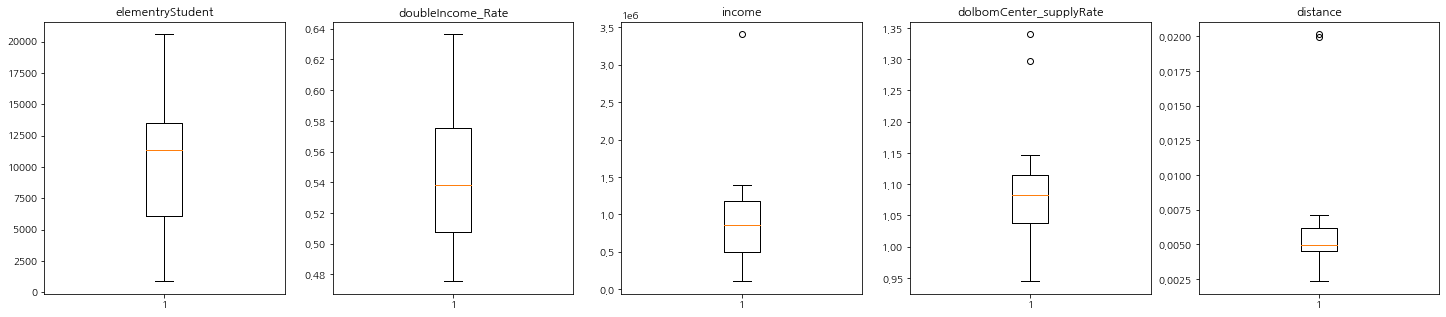

In [29]:
plt.figure(figsize=(25,5))
for n,i in enumerate(features.columns):
    plt.subplot(1,5,n+1)
    plt.boxplot(features[i])
    plt.title(i)
plt.show()

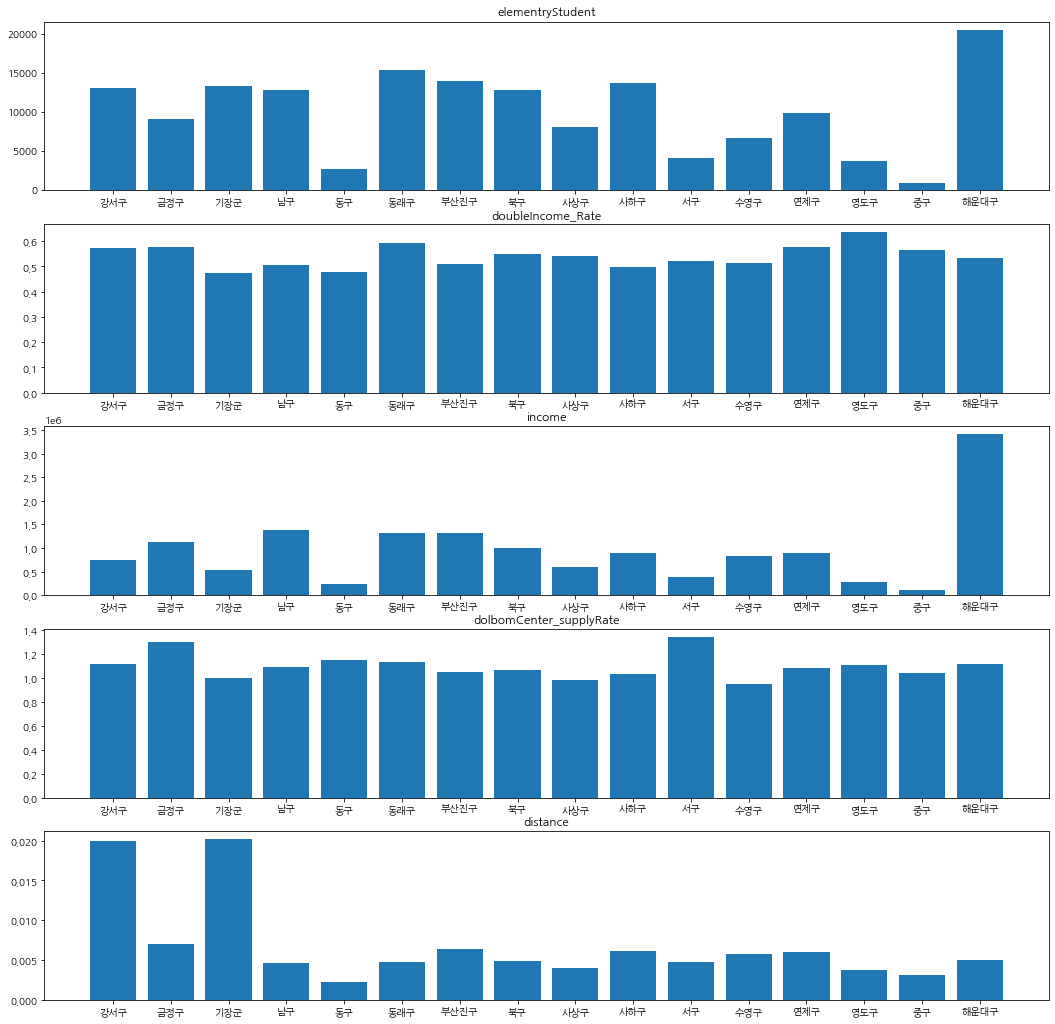

In [30]:
plt.figure(figsize=(18,18))
for n,i in enumerate(features.columns):
    plt.subplot(len(features.columns),1,n+1)
    plt.bar(features.index,features[i],)
    plt.title(i)
plt.show()

## 군집화

In [31]:
rs = RobustScaler()
scaled = rs.fit_transform(features)
display(scaled)

array([[ 0.24740104,  0.53907118, -0.1721562 ,  0.36173618,  8.73691956],
       [-0.30510311,  0.59253535,  0.39263192,  2.7879525 ,  1.23771424],
       [ 0.2797738 , -0.92704372, -0.47786652, -1.17072435,  8.82959055],
       [ 0.20568216, -0.46751489,  0.77624161,  0.08202475, -0.19061738],
       [-1.17402052, -0.88354077, -0.91931054,  0.82709179, -1.53143417],
       [ 0.55893807,  0.83331373,  0.67329683,  0.58284203, -0.14102842],
       [ 0.36131523, -0.44241694,  0.68828829, -0.50581015,  0.83438517],
       [ 0.20188954,  0.18606881,  0.21879612, -0.2354105 , -0.04512184],
       [-0.44299211,  0.04515112, -0.38325394, -1.29650715, -0.52287434],
       [ 0.32162812, -0.61472405,  0.03503948, -0.68133708,  0.69029611],
       [-0.97653313, -0.23329853, -0.71520782,  3.34910599, -0.08938406],
       [-0.62083912, -0.36931089, -0.03503948, -1.81072887,  0.50250204],
       [-0.20188954,  0.58802076,  0.0413526 , -0.08202475,  0.64255242],
       [-1.02976533,  1.44620413, -0.8

#### K-means

In [32]:
kmeans_output = features.copy()

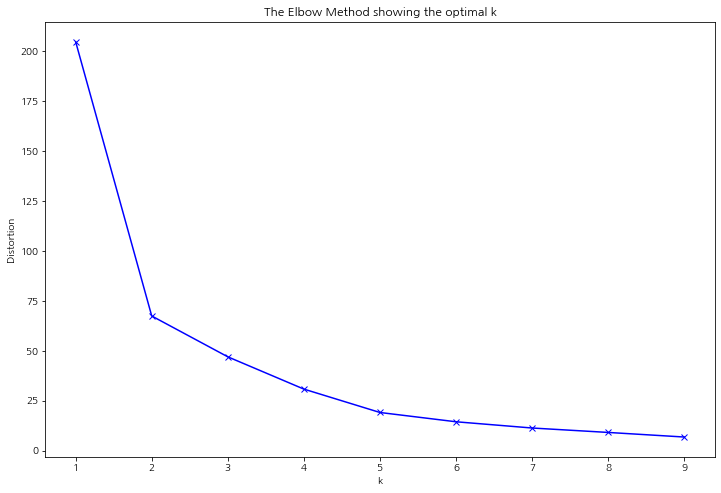

In [33]:
# Elbow Method - Kmeans
distortions, K = [], range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(scaled)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(12,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [34]:
# Silhouette Score - Kmeans
k_range, best_n, best_silhouette_score, score_list = range(3,16), -1, -1, []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=200)
    kmeans.fit(scaled)
    clusters = kmeans.predict(scaled)
    score=silhouette_score(scaled, clusters)
    score_list.append([k,score])
    
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score = score
silhouette_df = pd.DataFrame(score_list, columns=['k','silhouette_score'])
display(silhouette_df)
print('best_k: {}, score: {:.4}'.format(silhouette_df['k'][silhouette_df['silhouette_score'].idxmax()],silhouette_df['silhouette_score'][silhouette_df['silhouette_score'].idxmax()]))

,k,silhouette_score
0,3,0.346021
1,4,0.440623
2,5,0.401476
3,6,0.353007
4,7,0.344944
5,8,0.307198
6,9,0.210132
7,10,0.176722
8,11,0.153358
9,12,0.106466


best_k: 4, score: 0.4406


In [35]:
kmeanModel = KMeans(n_clusters=4, random_state=42)
kmeans_output['cluster'] = kmeanModel.fit_predict(scaled)
pd.pivot_table(data=kmeans_output.reset_index(),index=['cluster','gu'])

distance  dolbomCenter_supplyRate  doubleIncome_Rate  \
cluster gu                                                           
0       강서구   0.019992                 1.110687           0.574803   
        기장군   0.020152                 0.993274           0.475309   
1       남구    0.004631                 1.089256           0.506494   
        동구    0.002323                 1.146341           0.478261   
        동래구   0.004716                 1.127628           0.594771   
        부산진구  0.006394                 1.044218           0.508197   
        북구    0.004881                 1.064935           0.550847   
        사상구   0.004059                 0.983636           0.541284   
        사하구   0.006146                 1.030769           0.496503   
        수영구   0.005823                 0.944238           0.513158   
        연제구   0.006064                 1.076687           0.578125   
        영도구   0.003778                 1.101299           0.636364   
        중구    0.003093                 1.040816           0.566667   
2       금정구   0.007088                 1.296578           0.578431   
        서구    0.004805                 1.339572           0.522388   
3       해운대구  0.005036                 1.110439           0.535156   

              elementryStudent     income  
cluster gu                                 
0       강서구            13161.0   745321.0  
        기장군            13400.0   538645.0  
1       남구             12853.0  1386487.0  
        동구              2667.0   240206.0  
        동래구            15461.0  1316891.0  
        부산진구           14002.0  1327026.0  
        북구             12825.0  1009625.0  
        사상구             8064.0   602608.0  
        사하구            13709.0   885396.0  
        수영구             6751.0   838019.0  
        연제구             9844.0   889664.0  
        영도구             3732.0   287139.0  
        중구               877.0   103614.0  
2       금정구             9082.0  1127147.0  
        서구              4125.0   378190.0  
3       해운대구           20587.0  3404845.0

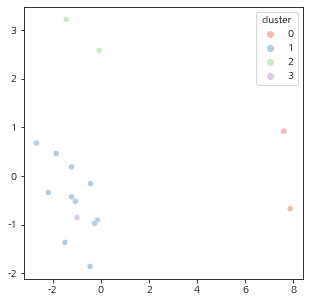

In [36]:
# PCA
temp_df = pd.DataFrame(PCA(n_components=2).fit_transform(scaled))
temp_df.index= features.index
temp_df['cluster'] = kmeans_output['cluster']
temp_df
f,ax = plt.subplots(1,1, figsize=(5,5))
sns.scatterplot(x=temp_df.iloc[:,0],y=temp_df.iloc[:,1], hue=temp_df['cluster'],palette='Pastel1')
plt.xlabel('')
plt.ylabel('')
plt.savefig('kmeans')
plt.show()

#### Mini Batch K-means

In [37]:
MiniBatchKMeans_output = features.copy()

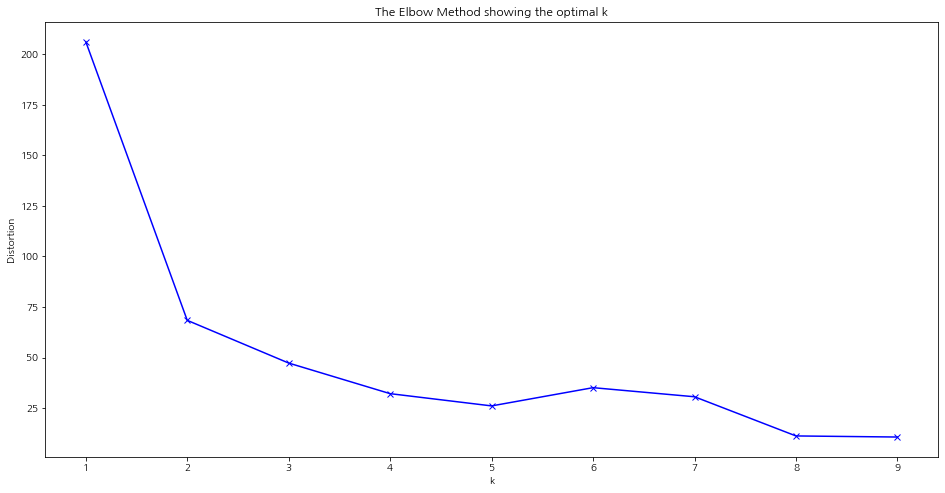

In [38]:
# Elbow Method - Mini Batch Kmeans
distortions, K = [], range(1,10)
for k in K:
    MiniBatchKMeansModel = MiniBatchKMeans(n_clusters=k, random_state=42)
    MiniBatchKMeansModel.fit(scaled)
    distortions.append(MiniBatchKMeansModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [39]:
# Silhouette Score - Mini Batch Kmeans
k_range, best_n, best_silhouette_score, score_list = range(3,16), -1, -1, []
for k in k_range:
    miniBatchKMeansModel = MiniBatchKMeans(n_clusters=k, random_state=200)
    miniBatchKMeansModel.fit(scaled)
    clusters = miniBatchKMeansModel.predict(scaled)
    score=silhouette_score(scaled, clusters)
    score_list.append([k,score])
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score = score
silhouette_df = pd.DataFrame(score_list, columns=['k','silhouette_score'])
display(silhouette_df)
print('best_k: {}, score: {:.4}'.format(silhouette_df['k'][silhouette_df['silhouette_score'].idxmax()],silhouette_df['silhouette_score'][silhouette_df['silhouette_score'].idxmax()]))

,k,silhouette_score
0,3,0.427319
1,4,0.357290
2,5,0.287637
3,6,0.353007
4,7,0.287437
5,8,0.138426
6,9,0.278790
7,10,0.109367
8,11,0.133860
9,12,0.052829


best_k: 3, score: 0.4273


In [40]:
miniBatchKMeansModel = MiniBatchKMeans(n_clusters=9, random_state=42)
miniBatchKMeansModel.fit(scaled)
MiniBatchKMeans_output['cluster'] = miniBatchKMeansModel.labels_
pd.pivot_table(data=MiniBatchKMeans_output.reset_index(),index=['cluster','gu'])

distance  dolbomCenter_supplyRate  doubleIncome_Rate  \
cluster gu                                                           
0       금정구   0.007088                 1.296578           0.578431   
        서구    0.004805                 1.339572           0.522388   
1       남구    0.004631                 1.089256           0.506494   
        부산진구  0.006394                 1.044218           0.508197   
        사하구   0.006146                 1.030769           0.496503   
2       강서구   0.019992                 1.110687           0.574803   
        기장군   0.020152                 0.993274           0.475309   
3       사상구   0.004059                 0.983636           0.541284   
        수영구   0.005823                 0.944238           0.513158   
4       연제구   0.006064                 1.076687           0.578125   
5       해운대구  0.005036                 1.110439           0.535156   
6       동래구   0.004716                 1.127628           0.594771   
        북구    0.004881                 1.064935           0.550847   
7       동구    0.002323                 1.146341           0.478261   
        영도구   0.003778                 1.101299           0.636364   
8       중구    0.003093                 1.040816           0.566667   

              elementryStudent     income  
cluster gu                                 
0       금정구             9082.0  1127147.0  
        서구              4125.0   378190.0  
1       남구             12853.0  1386487.0  
        부산진구           14002.0  1327026.0  
        사하구            13709.0   885396.0  
2       강서구            13161.0   745321.0  
        기장군            13400.0   538645.0  
3       사상구             8064.0   602608.0  
        수영구             6751.0   838019.0  
4       연제구             9844.0   889664.0  
5       해운대구           20587.0  3404845.0  
6       동래구            15461.0  1316891.0  
        북구             12825.0  1009625.0  
7       동구              2667.0   240206.0  
        영도구             3732.0   287139.0  
8       중구               877.0   103614.0

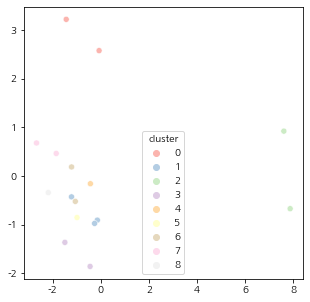

In [41]:
# PCA
temp_df = pd.DataFrame(PCA(n_components=2).fit_transform(scaled))
temp_df.index= features.index
temp_df['cluster'] = MiniBatchKMeans_output['cluster']
temp_df
f,ax = plt.subplots(1,1, figsize=(5,5))
sns.scatterplot(x=temp_df.iloc[:,0],y=temp_df.iloc[:,1], hue=temp_df['cluster'],palette='Pastel1')
plt.xlabel('')
plt.ylabel('')
plt.savefig('miniBatchKMeans')
plt.show()

#### MeanShift

In [42]:
MeanShift_output = features.copy()

In [43]:
best_bandwidth = estimate_bandwidth(scaled)
meanshift = MeanShift(bandwidth = best_bandwidth)
cluster_labels = meanshift.fit_predict(scaled)
MeanShift_output['cluster'] = cluster_labels
print('best bandwidth cluster labels 유형:',np.unique(cluster_labels))
print('bandwidth 값:', round(best_bandwidth,3))
pd.pivot_table(data=MeanShift_output.reset_index(),index=['cluster','gu'])

best bandwidth cluster labels 유형: [0 1 2 3]
bandwidth 값: 2.785


distance  dolbomCenter_supplyRate  doubleIncome_Rate  \
cluster gu                                                           
0       남구    0.004631                 1.089256           0.506494   
        동구    0.002323                 1.146341           0.478261   
        동래구   0.004716                 1.127628           0.594771   
        부산진구  0.006394                 1.044218           0.508197   
        북구    0.004881                 1.064935           0.550847   
        사상구   0.004059                 0.983636           0.541284   
        사하구   0.006146                 1.030769           0.496503   
        수영구   0.005823                 0.944238           0.513158   
        연제구   0.006064                 1.076687           0.578125   
        영도구   0.003778                 1.101299           0.636364   
        중구    0.003093                 1.040816           0.566667   
1       강서구   0.019992                 1.110687           0.574803   
        기장군   0.020152                 0.993274           0.475309   
2       금정구   0.007088                 1.296578           0.578431   
        서구    0.004805                 1.339572           0.522388   
3       해운대구  0.005036                 1.110439           0.535156   

              elementryStudent     income  
cluster gu                                 
0       남구             12853.0  1386487.0  
        동구              2667.0   240206.0  
        동래구            15461.0  1316891.0  
        부산진구           14002.0  1327026.0  
        북구             12825.0  1009625.0  
        사상구             8064.0   602608.0  
        사하구            13709.0   885396.0  
        수영구             6751.0   838019.0  
        연제구             9844.0   889664.0  
        영도구             3732.0   287139.0  
        중구               877.0   103614.0  
1       강서구            13161.0   745321.0  
        기장군            13400.0   538645.0  
2       금정구             9082.0  1127147.0  
        서구              4125.0   378190.0  
3       해운대구           20587.0  3404845.0

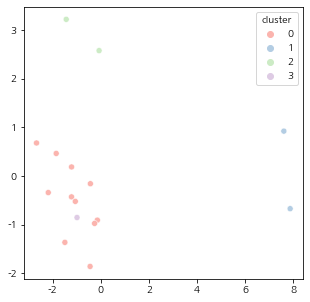

In [44]:
# PCA
temp_df = pd.DataFrame(PCA(n_components=2).fit_transform(scaled))
temp_df.index= features.index
temp_df['cluster'] = MeanShift_output['cluster']
temp_df
f,ax = plt.subplots(1,1, figsize=(5,5))
sns.scatterplot(x=temp_df.iloc[:,0],y=temp_df.iloc[:,1], hue=temp_df['cluster'],palette='Pastel1')
plt.xlabel('')
plt.ylabel('')
plt.savefig('MeanShift_output')
plt.show()

#### Dbscan

In [45]:
DBSCAN_output = features.copy()

In [46]:
for min_sample in range(1,7): # 오브젝트의 절반정도만 시도
    for ep in list(np.arange(0.1,5,0.1)):
        try:
            dbscan = DBSCAN(eps = ep, min_samples=min_sample)
            clusters = dbscan.fit_predict(scaled)
            score = silhouette_score(DBSCAN_output,clusters)
            if score<0:
                continue
            else:
                print("Eps: {:.3f}, Min Samples: {}".format(ep,min_sample))
                print("DBSCAN Clustering: ", score)
                print(clusters)
        except:
            print('pass')

pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
Eps: 1.200, Min Samples: 2
DBSCAN Clustering:  0.17468658298760079
[-1 -1 -1  0 -1  0  0  0 -1  0 -1 -1  0 -1 -1 -1]
Eps: 1.500, Min Samples: 2
DBSCAN Clustering:  0.11913152997736451
[-1 -1 -1  0 -1  0  0  0  0  0 -1  0  0  1  1 -1]
Eps: 1.600, Min Samples: 2
DBSCAN Clustering:  0.0944021368446673
[-1 -1 -1  0 -1  0  0  0  0  0 -1  0  0  0  0 -1]
Eps: 1.700, Min Samples: 2
DBSCAN Clustering:  0.0944021368446673
[-1 -1 -1  0 -1  0  0  0  0  0 -1  0  0  0  0 -1]
Eps: 1.800, Min Samples: 2
DBSCAN Clustering:  0.0944021368446673
[-1 -1 -1  0 -1  0  0  0  0  0 -1  0  0  0  0 -1]
Eps: 1.900, Min Samples: 2
DBSCAN Clustering:  0.0944021368446673
[-1 -1 -1  0 -1  0  0  0  0  0 -1  0  0  0  0 -1]
Eps: 2.000, Min Samples: 2
DBSCAN Clustering:  0.13390068568608782
[-1 -1 -1  0  0  0  0  0  0  0 -1  0  0  0  0 -1]
Eps: 2.100, Min Samples: 2
DBSCAN Clustering:  0.13390068568608782
[-1 -1 -1  0  0  0  0  0  0  0 -1  0  0  0  0 -1

In [47]:
# 최적의 하이퍼 파라미터: Eps: 2.800, Min Samples: 3
dbscan = DBSCAN(eps = 2.8, min_samples=3)
DBSCAN_output['cluster'] = dbscan.fit_predict(scaled)
pd.pivot_table(data=DBSCAN_output.reset_index(),index=['cluster','gu'])

distance  dolbomCenter_supplyRate  doubleIncome_Rate  \
cluster gu                                                           
-1      강서구   0.019992                 1.110687           0.574803   
        기장군   0.020152                 0.993274           0.475309   
        해운대구  0.005036                 1.110439           0.535156   
 0      금정구   0.007088                 1.296578           0.578431   
        남구    0.004631                 1.089256           0.506494   
        동구    0.002323                 1.146341           0.478261   
        동래구   0.004716                 1.127628           0.594771   
        부산진구  0.006394                 1.044218           0.508197   
        북구    0.004881                 1.064935           0.550847   
        사상구   0.004059                 0.983636           0.541284   
        사하구   0.006146                 1.030769           0.496503   
        서구    0.004805                 1.339572           0.522388   
        수영구   0.005823                 0.944238           0.513158   
        연제구   0.006064                 1.076687           0.578125   
        영도구   0.003778                 1.101299           0.636364   
        중구    0.003093                 1.040816           0.566667   

              elementryStudent     income  
cluster gu                                 
-1      강서구            13161.0   745321.0  
        기장군            13400.0   538645.0  
        해운대구           20587.0  3404845.0  
 0      금정구             9082.0  1127147.0  
        남구             12853.0  1386487.0  
        동구              2667.0   240206.0  
        동래구            15461.0  1316891.0  
        부산진구           14002.0  1327026.0  
        북구             12825.0  1009625.0  
        사상구             8064.0   602608.0  
        사하구            13709.0   885396.0  
        서구              4125.0   378190.0  
        수영구             6751.0   838019.0  
        연제구             9844.0   889664.0  
        영도구             3732.0   287139.0  
        중구               877.0   103614.0

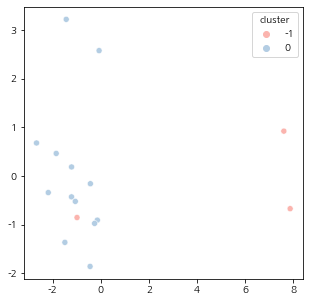

In [48]:
# PCA
temp_df = pd.DataFrame(PCA(n_components=2).fit_transform(scaled))
temp_df.index= features.index
temp_df['cluster'] = DBSCAN_output['cluster']
temp_df
f,ax = plt.subplots(1,1, figsize=(5,5))
sns.scatterplot(x=temp_df.iloc[:,0],y=temp_df.iloc[:,1], hue=temp_df['cluster'],palette='Pastel1')
plt.xlabel('')
plt.ylabel('')
plt.savefig('DBSCAN_output')
plt.show()
# 강서, 기장, 해운대가 예외로 나옴

#### Spectral Clustering

In [49]:
SpectralClustering_output = features.copy()

In [50]:
for n_cluster in range(1,16):
    for n_init in range(1,16):
        try:
            clusters = SpectralClustering(n_clusters=n_cluster, n_init=n_init).fit_predict(scaled)
            score = silhouette_score(SpectralClustering_output,clusters)
            print(score)
            if score<0:
                continue
            else:
                print('n_cluster:{}, n_init:{}'.format(n_cluster, n_init))
                print(score)
        except:
            print('pass')
# 결과가 안좋다.

pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
-0.24782576408711446
-0.24782576408711446
-0.24782576408711446
-0.24782576408711446
-0.24782576408711446
-0.24782576408711446
-0.24782576408711446
-0.24782576408711446
-0.24782576408711446
-0.24782576408711446
-0.24782576408711446
-0.24782576408711446
-0.24782576408711446
-0.24782576408711446
-0.24782576408711446
-0.3314713543808998
-0.3314713543808998
-0.3314713543808998
-0.3314713543808998
-0.3314713543808998
-0.3314713543808998
-0.3314713543808998
-0.3314713543808998
-0.3314713543808998
-0.3314713543808998
-0.3314713543808998
-0.3314713543808998
-0.3314713543808998
-0.3314713543808998
-0.3314713543808998
-0.058428192923007716
-0.058428192923007716
-0.058428192923007716
-0.058428192923007716
-0.058428192923007716
-0.058428192923007716
-0.058428192923007716
-0.058428192923007716
-0.058428192923007716
-0.058428192923007716
-0.058428192923007716
-0.058428192923007716
-0.058428192923007716
-0.058428192923007716
-0

#### Gaussian Mixture

In [51]:
GaussianMixture_output = features.copy()

In [52]:
for n_component in range(2,16):
    clusters = GaussianMixture(n_components=n_component, random_state=42).fit_predict(scaled)
    score = silhouette_score(GaussianMixture_output,clusters)
    if score<0:
        continue
    else:
        print('n:',n_component)
        print(score)
GaussianMixture_output['cluster'] = GaussianMixture(n_components=5, random_state=42).fit_predict(scaled)
pd.pivot_table(data=GaussianMixture_output.reset_index(),index=['cluster','gu'])

n: 5
0.004402358077733509


distance  dolbomCenter_supplyRate  doubleIncome_Rate  \
cluster gu                                                           
0       부산진구  0.006394                 1.044218           0.508197   
        북구    0.004881                 1.064935           0.550847   
        사하구   0.006146                 1.030769           0.496503   
        수영구   0.005823                 0.944238           0.513158   
        연제구   0.006064                 1.076687           0.578125   
1       강서구   0.019992                 1.110687           0.574803   
        기장군   0.020152                 0.993274           0.475309   
2       금정구   0.007088                 1.296578           0.578431   
        서구    0.004805                 1.339572           0.522388   
3       남구    0.004631                 1.089256           0.506494   
        동래구   0.004716                 1.127628           0.594771   
        해운대구  0.005036                 1.110439           0.535156   
4       동구    0.002323                 1.146341           0.478261   
        사상구   0.004059                 0.983636           0.541284   
        영도구   0.003778                 1.101299           0.636364   
        중구    0.003093                 1.040816           0.566667   

              elementryStudent     income  
cluster gu                                 
0       부산진구           14002.0  1327026.0  
        북구             12825.0  1009625.0  
        사하구            13709.0   885396.0  
        수영구             6751.0   838019.0  
        연제구             9844.0   889664.0  
1       강서구            13161.0   745321.0  
        기장군            13400.0   538645.0  
2       금정구             9082.0  1127147.0  
        서구              4125.0   378190.0  
3       남구             12853.0  1386487.0  
        동래구            15461.0  1316891.0  
        해운대구           20587.0  3404845.0  
4       동구              2667.0   240206.0  
        사상구             8064.0   602608.0  
        영도구             3732.0   287139.0  
        중구               877.0   103614.0

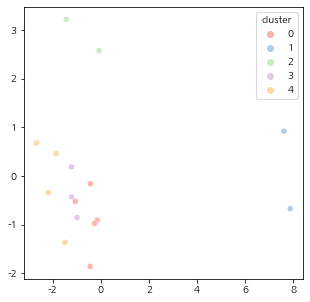

In [53]:
# PCA
temp_df = pd.DataFrame(PCA(n_components=2).fit_transform(scaled))
temp_df.index= features.index
temp_df['cluster'] = GaussianMixture_output['cluster']
temp_df
f,ax = plt.subplots(1,1, figsize=(5,5))
sns.scatterplot(x=temp_df.iloc[:,0],y=temp_df.iloc[:,1], hue=temp_df['cluster'],palette='Pastel1')
plt.xlabel('')
plt.ylabel('')
plt.savefig('GaussianMixture_output')
plt.show()

#### Birch

In [54]:
Birch_output = features.copy()

In [55]:
for i in range(2,15):
    brc = Birch(n_clusters=i)
    clusters = brc.fit_predict(scaled)
    score = silhouette_score(Birch_output,clusters)
    if score<0:
        continue
    else:
        print('i:',i)
        print(score)  
Birch_output['cluster']=Birch(n_clusters=5).fit_predict(scaled)
pd.pivot_table(data=Birch_output.reset_index(),index=['cluster','gu'])

i: 5
0.10205218064093152
i: 6
0.017212153874249014


distance  dolbomCenter_supplyRate  doubleIncome_Rate  \
cluster gu                                                           
0       남구    0.004631                 1.089256           0.506494   
        동래구   0.004716                 1.127628           0.594771   
        부산진구  0.006394                 1.044218           0.508197   
        북구    0.004881                 1.064935           0.550847   
        사상구   0.004059                 0.983636           0.541284   
        사하구   0.006146                 1.030769           0.496503   
        수영구   0.005823                 0.944238           0.513158   
        연제구   0.006064                 1.076687           0.578125   
1       동구    0.002323                 1.146341           0.478261   
        영도구   0.003778                 1.101299           0.636364   
        중구    0.003093                 1.040816           0.566667   
2       금정구   0.007088                 1.296578           0.578431   
        서구    0.004805                 1.339572           0.522388   
3       해운대구  0.005036                 1.110439           0.535156   
4       강서구   0.019992                 1.110687           0.574803   
        기장군   0.020152                 0.993274           0.475309   

              elementryStudent     income  
cluster gu                                 
0       남구             12853.0  1386487.0  
        동래구            15461.0  1316891.0  
        부산진구           14002.0  1327026.0  
        북구             12825.0  1009625.0  
        사상구             8064.0   602608.0  
        사하구            13709.0   885396.0  
        수영구             6751.0   838019.0  
        연제구             9844.0   889664.0  
1       동구              2667.0   240206.0  
        영도구             3732.0   287139.0  
        중구               877.0   103614.0  
2       금정구             9082.0  1127147.0  
        서구              4125.0   378190.0  
3       해운대구           20587.0  3404845.0  
4       강서구            13161.0   745321.0  
        기장군            13400.0   538645.0

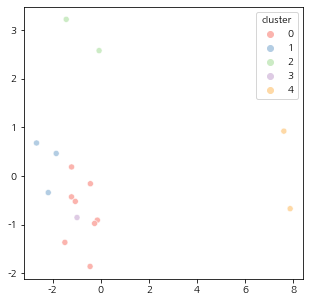

In [56]:
# PCA
temp_df = pd.DataFrame(PCA(n_components=2).fit_transform(scaled))
temp_df.index= features.index
temp_df['cluster'] = Birch_output['cluster']
temp_df
f,ax = plt.subplots(1,1, figsize=(5,5))
sns.scatterplot(x=temp_df.iloc[:,0],y=temp_df.iloc[:,1], hue=temp_df['cluster'],palette='Pastel1')
plt.xlabel('')
plt.ylabel('')
plt.savefig('Birch_output')
plt.show()

#### Affinity Propagation

In [57]:
AffinityPropagation_output = features.copy()

In [58]:
AP = AffinityPropagation(random_state=42)
AffinityPropagation_output['cluster'] = AP.fit_predict(scaled)
pd.pivot_table(data=AffinityPropagation_output.reset_index(),index=['cluster','gu'])

distance  dolbomCenter_supplyRate  doubleIncome_Rate  \
cluster gu                                                           
0       강서구   0.019992                 1.110687           0.574803   
        기장군   0.020152                 0.993274           0.475309   
1       남구    0.004631                 1.089256           0.506494   
        동래구   0.004716                 1.127628           0.594771   
        부산진구  0.006394                 1.044218           0.508197   
        북구    0.004881                 1.064935           0.550847   
        사상구   0.004059                 0.983636           0.541284   
        사하구   0.006146                 1.030769           0.496503   
        수영구   0.005823                 0.944238           0.513158   
        연제구   0.006064                 1.076687           0.578125   
2       금정구   0.007088                 1.296578           0.578431   
        서구    0.004805                 1.339572           0.522388   
3       동구    0.002323                 1.146341           0.478261   
        영도구   0.003778                 1.101299           0.636364   
        중구    0.003093                 1.040816           0.566667   
4       해운대구  0.005036                 1.110439           0.535156   

              elementryStudent     income  
cluster gu                                 
0       강서구            13161.0   745321.0  
        기장군            13400.0   538645.0  
1       남구             12853.0  1386487.0  
        동래구            15461.0  1316891.0  
        부산진구           14002.0  1327026.0  
        북구             12825.0  1009625.0  
        사상구             8064.0   602608.0  
        사하구            13709.0   885396.0  
        수영구             6751.0   838019.0  
        연제구             9844.0   889664.0  
2       금정구             9082.0  1127147.0  
        서구              4125.0   378190.0  
3       동구              2667.0   240206.0  
        영도구             3732.0   287139.0  
        중구               877.0   103614.0  
4       해운대구           20587.0  3404845.0

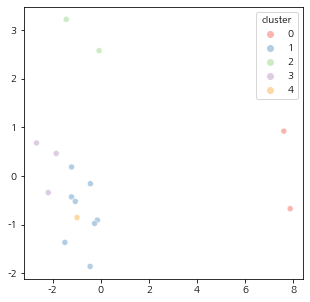

In [59]:
# PCA
temp_df = pd.DataFrame(PCA(n_components=2).fit_transform(scaled))
temp_df.index= features.index
temp_df['cluster'] = AffinityPropagation_output['cluster']
temp_df
f,ax = plt.subplots(1,1, figsize=(5,5))
sns.scatterplot(x=temp_df.iloc[:,0],y=temp_df.iloc[:,1], hue=temp_df['cluster'],palette='Pastel1')
plt.xlabel('')
plt.ylabel('')
plt.savefig('AffinityPropagation_output')
plt.show()

#### Agglomerative

In [60]:
AgglomerativeClustering_output = features.copy()

In [61]:
for i in range(2,16):
    clusters = AgglomerativeClustering(n_clusters=i).fit_predict(scaled)
    score = silhouette_score(AgglomerativeClustering_output,clusters)
    if score<0:
        continue
    else:
        print('i:',i)
        print(score)    

i: 5
0.10205218064093152
i: 6
0.017212153874249014


In [62]:
AgglomerativeClustering_output['cluster']=AgglomerativeClustering(n_clusters=5).fit_predict(scaled)
pd.pivot_table(data=AgglomerativeClustering_output.reset_index(),index=['cluster','gu'])

distance  dolbomCenter_supplyRate  doubleIncome_Rate  \
cluster gu                                                           
0       남구    0.004631                 1.089256           0.506494   
        동래구   0.004716                 1.127628           0.594771   
        부산진구  0.006394                 1.044218           0.508197   
        북구    0.004881                 1.064935           0.550847   
        사상구   0.004059                 0.983636           0.541284   
        사하구   0.006146                 1.030769           0.496503   
        수영구   0.005823                 0.944238           0.513158   
        연제구   0.006064                 1.076687           0.578125   
1       동구    0.002323                 1.146341           0.478261   
        영도구   0.003778                 1.101299           0.636364   
        중구    0.003093                 1.040816           0.566667   
2       금정구   0.007088                 1.296578           0.578431   
        서구    0.004805                 1.339572           0.522388   
3       해운대구  0.005036                 1.110439           0.535156   
4       강서구   0.019992                 1.110687           0.574803   
        기장군   0.020152                 0.993274           0.475309   

              elementryStudent     income  
cluster gu                                 
0       남구             12853.0  1386487.0  
        동래구            15461.0  1316891.0  
        부산진구           14002.0  1327026.0  
        북구             12825.0  1009625.0  
        사상구             8064.0   602608.0  
        사하구            13709.0   885396.0  
        수영구             6751.0   838019.0  
        연제구             9844.0   889664.0  
1       동구              2667.0   240206.0  
        영도구             3732.0   287139.0  
        중구               877.0   103614.0  
2       금정구             9082.0  1127147.0  
        서구              4125.0   378190.0  
3       해운대구           20587.0  3404845.0  
4       강서구            13161.0   745321.0  
        기장군            13400.0   538645.0

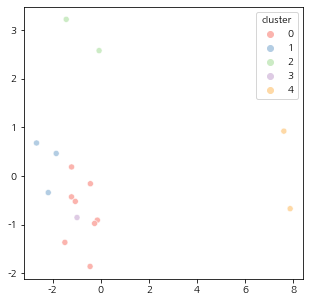

In [63]:
# PCA
temp_df = pd.DataFrame(PCA(n_components=2).fit_transform(scaled))
temp_df.index= features.index
temp_df['cluster'] = AgglomerativeClustering_output['cluster']
temp_df
f,ax = plt.subplots(1,1, figsize=(5,5))
sns.scatterplot(x=temp_df.iloc[:,0],y=temp_df.iloc[:,1], hue=temp_df['cluster'],palette='Pastel1')
plt.xlabel('')
plt.ylabel('')
plt.savefig('AgglomerativeClustering_output')
plt.show()

In [64]:
result_clustering_df = pd.concat([kmeans_output['cluster'],MiniBatchKMeans_output['cluster'],MeanShift_output['cluster'],DBSCAN_output['cluster'],GaussianMixture_output['cluster'],Birch_output['cluster'],AffinityPropagation_output['cluster'],AgglomerativeClustering_output['cluster']],axis=1)
result_clustering_df.columns = ['kmeans','minibatch_kmeans','meanshift','dbscan','gaussianMixture','birch','affinityPropagation','agg|lomerative']
display(result_clustering_df)

,kmeans,minibatch_kmeans,meanshift,dbscan,gaussianMixture,birch,affinityPropagation,agg|lomerative
gu,,,,,,,,
강서구,0,2,1,-1,1,4,0,4
금정구,2,0,2,0,2,2,2,2
기장군,0,2,1,-1,1,4,0,4
남구,1,1,0,0,3,0,1,0
동구,1,7,0,0,4,1,3,1
동래구,1,6,0,0,3,0,1,0
부산진구,1,1,0,0,0,0,1,0
북구,1,6,0,0,0,0,1,0
사상구,1,3,0,0,4,0,1,0


군집번호(횟수)
- 강한군집1(7): 강서구, 기장군
- 강한군집2(7): 해운대구
- 강한군집3(7): 금정구, 서구
- 약한군집4(4): 동구, 영도구, 중구
- 그외군집5
---
강한 군집 정의: 7회이상 경향성

약한 군집 정의: 4회이상 경향성

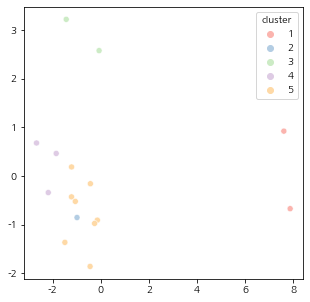

,distance,dolbomCenter_supplyRate,doubleIncome_Rate,elementryStudent,income
cluster,,,,,
1,0.020072,1.051980,0.525056,13280.500000,6.419830e+05
2,0.005036,1.110439,0.535156,20587.000000,3.404845e+06
3,0.005947,1.318075,0.550410,6603.500000,7.526685e+05
4,0.003065,1.096152,0.560430,2425.333333,2.103197e+05
5,0.005339,1.045171,0.536172,11688.625000,1.031964e+06


In [65]:
clusters = [1,3,1,5,4,5,5,5,5,5,3,5,5,4,4,2]
temp_df['cluster'] = clusters
f,ax = plt.subplots(1,1, figsize=(5,5))
sns.scatterplot(x=temp_df.iloc[:,0],y=temp_df.iloc[:,1], hue=temp_df['cluster'], palette='Pastel1')
plt.xlabel('')
plt.ylabel('')
plt.savefig('result_clustering')
plt.show()
features['cluster'] = clusters
pd.pivot_table(data=features,index=['cluster'])

학교와 돌봄센터의 거리 ↑ | 돌봄센터 포화율 ↓ | 맞벌이가구 비율 ↑ |  초등학생 수 ↑ | 소득수준 ↓

#### 클러스터1(강서구, 기장군) 선정

## 시각화

In [66]:
dongData = pd.read_excel("C:/Users/dongjae/Downloads/pusan.xlsx")
geo_path ="C:/Users/dongjae/Downloads/LSMD_ADM_SECT_UMD_26.json"
pusan = json.load(open(geo_path, encoding='utf-8'))

In [67]:
df1 = school_loc_df[(school_loc_df['gu']=='강서구')|(school_loc_df['gu']=='기장군')].copy()
df2 = dolbom_loc_df[(dolbom_loc_df['gu']=='강서구')|(dolbom_loc_df['gu']=='기장군')].copy()

In [68]:
# 학교 및 돌봄시설
pusan_map = folium.Map(location=[35.184, 129.021], zoom_start=11, tiles='CartoDB positron')
pusan_map.choropleth(geo_data=pusan, data = dongData, columns=['dong','counts'],fill_opacity=0.0,line_opacity=0.5,)
for i in range(len(df1)): # 학교
    folium.Marker([df1.iloc[i,:]['lat'],df1.iloc[i,:]['lng']], icon = folium.Icon(color = "red"),
                 popup=df1.iloc[i,:]['gu'] +'\n'+df1.iloc[i,:]['name']).add_to(pusan_map)
for i in range(len(df2)): # 돌봄시설
    folium.Marker([df2.iloc[i,:]['lat'],df2.iloc[i,:]['lng']], icon = folium.Icon(color = "green"),
                  popup = df2.iloc[i,:]['gu'] +'\n'+df2.iloc[i,:]['name']).add_to(pusan_map)
# pusan_map.save('pusan_basic.html')
display(pusan_map)

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:407: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [69]:
# 돌봄시설 히트맵
steps = 100 # heatmap 색상
color_map= cm.LinearColormap(colors=['blue', 'green', 'yellow', 'orange', 'red'], vmin=0.4, vmax=0.9).to_step(n=10)

gradient_map=defaultdict(dict)
for i in range(steps):
    gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)

pusan_map = folium.Map(location=[35.184, 129.021], zoom_start=11, tiles='CartoDB positron')
pusan_map.choropleth(geo_data=pusan, data = dongData, columns=['dong','counts'],fill_opacity=0.0,line_opacity=0.5,)
for i in range(len(df1)):
    folium.Marker([df1.iloc[i,:]['lat'],df1.iloc[i,:]['lng']], 
                  icon = folium.Icon(color = "red"),
                 popup=df1.iloc[i,:]['gu'] +'\n'+df1.iloc[i,:]['name']).add_to(pusan_map)
for i in range(len(df2)):
    folium.Marker([df2.iloc[i,:]['lat'],df2.iloc[i,:]['lng']], 
                  icon = folium.Icon(color = "green"),
                  popup = df2.iloc[i,:]['gu'] +'\n'+df2.iloc[i,:]['name']).add_to(pusan_map)
# Add heatmap
HeatMap(data=df2[['lat','lng']], radius=50, gradient=gradient_map).add_to(pusan_map)
color_map.caption='color bar' # colorbar 문구 설정
pusan_map.add_child(color_map)
# pusan_map.save('pusan_heatmap.html')
display(pusan_map)

In [70]:
# 우선 돌봄시설 공급이 필요한 500m이내 돌봄시설이 존재하지 않는 초등학교
df1.reset_index(inplace=True)
df1.drop('index', axis=1, inplace=True)
df2.reset_index(inplace=True)
df2.drop('index', axis=1, inplace=True)
df1['o'] = 0 # 0: default
for i in range(len(df1)):
    temp_school = df1.iloc[i,:]
    for j in range(len(df2)):
        temp_center= df2.iloc[j,:]
        dist = haversine((temp_school['lat'],temp_school['lng']),(temp_center['lat'],temp_center['lng']), unit = "m")
        if dist < 500:
            df1.iloc[i,5]= 1 # 1: 500m 이내 존재
df3 = df1[df1['o']==0]
display(df3)

,gu,name,location,lat,lng,o
0,강서구,가락초등학교,부산광역시 강서구 호계로 41,35.196340,128.895265,0
1,강서구,녹명초등학교,부산광역시 강서구 낙동남로 617,35.114894,128.886392,0
2,강서구,대사초등학교,부산광역시 강서구 낙동북로 73번길 29,35.220418,128.938549,0
3,강서구,대상초등학교,부산광역시 강서구 대저로 249,35.214120,128.980252,0
4,강서구,대저초등학교,부산광역시 강서구 대저로29번길 27,35.215319,128.954018,0
5,강서구,덕두초등학교,부산광역시 강서구 공항로791번길 68,35.175645,128.956214,0
6,강서구,명지초등학교,부산광역시 강서구 명지국제6로 296,35.102261,128.924117,0
7,강서구,배영초등학교,부산광역시 강서구 공항로 339번길 260,35.150203,128.945325,0
8,강서구,신호초등학교,부산광역시 강서구 신호산단2로 75번길 12,35.081970,128.878586,0
9,강서구,천가초등학교,부산광역시 강서구 동선길 135,35.052346,128.831268,0


In [71]:
pusan_map = folium.Map(location=[35.184, 129.021], zoom_start=11, tiles='CartoDB positron')
pusan_map.choropleth(geo_data=pusan, data = dongData, columns=['dong','counts'],fill_opacity=0.0,line_opacity=0.5,)
for i in range(len(df3)):
    folium.Marker([df3.iloc[i,:]['lat'],df3.iloc[i,:]['lng']], 
                  icon = folium.Icon(color = "red"),
                 popup=df3.iloc[i,:]['gu'] +'\n'+df3.iloc[i,:]['name']).add_to(pusan_map)
# pusan_map.save('pusan_needs_school.html')
pusan_map

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:407: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(
